In [1]:
import numpy as np
import matplotlib.pyplot as plt
from subprocess import call
import os
import pandas as pd
import glob

In [2]:
# simulate and count how many times the good option/ bad option wins:
def sim_winner_count():
    global pis, qs, l, lci, N, maxTime, Nrea, ic, ci_kwargs
    pichain = ','.join([str(pi) for pi in pis])
    qchain = ','.join([str(q) for q in qs])
    ci_kwargs_chain = ','.join([str(cikw) for cikw in ci_kwargs])
    simCall = f'python LES_model_gill.py -pis {pichain} -qs {qchain} -l {l} -lci {lci} -ci_kwargs {ci_kwargs_chain} '
    simCall += f'-N {N} -maxTime {maxTime} -Nrea {Nrea} -ic {ic} > simEnds.txt'
    call(simCall, shell=True)
    df = pd.read_csv('simEnds.txt', sep='\s+', names=['f0', 'f1', 'f2'])
    f1wins = len(df.query('f1 > f2 & f1 > f0'))
    f2wins = len(df.query('f2 > f1 & f2 > f0'))
    f0wins = len(df.query('f0 > f1 & f0 > f2'))
    f1f2draw = len(df.query('f1 == f2'))
    return f0wins,f1wins,f2wins,f1f2draw

    

In [60]:
df = pd.read_csv('simEnds.txt', sep='\s+', names=['f0', 'f1', 'f2'])
f1wins = len(df.query('f1 > f2 & f1 > f0'))
f2wins = len(df.query('f2 > f1 & f2 > f0'))
f0wins = len(df.query('f0 > f1 & f0 > f2'))
f1f2draw = len(df.query('f1 == f2'))
print(f0wins,f1wins,f2wins,f1f2draw)

0 89 111 0


In [5]:
pis, qs = [0.1, 0.1], [9.0, 10.0]
l, lci, N, maxTime, Nrea, ic = 0.6, 0.6, 1000, 70.0, 50, 'N'
# l, lci, N, maxTime, Nrea, ic = 0.1, 0.1, 1000, 70.0, 50, 'N'

# SIGMOID 1:
# changing x0: 
ci_kwargs_list = [[0,], [1, 0.2, 40], [1, 0.35, 40], [1, 0.5, 40], [1, 0.8, 40]]
# changing a:
# ci_kwargs_list = [[0,], [1, 0.5, 5], [1, 0.5, 10], [1, 0.5, 30], [1, 0.5, 100]]

# SIGMOID 2:
# changing x0: 
# ci_kwargs_list = [[0,], [2, 0.2, 3], [2, 0.5, 3], [2, 0.75, 3], [2, 1.0, 3]]
# changing a:
# ci_kwargs_list = [[0,], [2, 0.7, 1], [1, 0.7, 5], [1, 0.7, 12], [1, 0.7, 100]]


fi_win_counts = {'f0':[], 'f1':[], 'f2':[], 'f1f2draw':[]}

for ci_kwargs in ci_kwargs_list:
    f0wins, f1wins, f2wins, f1f2draw = sim_winner_count()
    if f0wins+f1wins+f2wins+f1f2draw != Nrea:
        print('oju!')
    print(f'{ci_kwargs}: ', f0wins/Nrea*100, f1wins/Nrea*100, f2wins/Nrea*100)
    fi_win_counts['f0'].append(f0wins)
    fi_win_counts['f1'].append(f1wins)
    fi_win_counts['f2'].append(f2wins)
    fi_win_counts['f1f2draw'].append(f1f2draw)

[0]:  0.0 36.0 64.0
[1, 0.2, 40]:  0.0 57.99999999999999 42.0
[1, 0.35, 40]:  0.0 46.0 54.0
[1, 0.5, 40]:  0.0 30.0 70.0
[1, 0.8, 40]:  0.0 0.0 100.0


TypeError: __init__() got an unexpected keyword argument 'ncols'

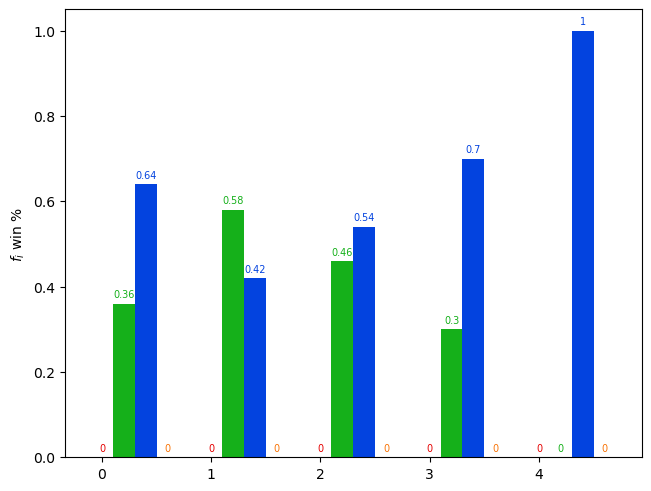

In [12]:
# shoud somehow label items of the ci_kwargs_list
# SIGMOID 1:
# changing x0:
# species = ("linear", r"$\sigma_1 (0.2,40)$", r"$\sigma_1 (0.35,40)$", r"$\sigma_1 (0.5,40)$", r"$\sigma_1 (0.8,40)$")
# changing a:
# species = ("linear", r"$\sigma_1 (0.35,5)$", r"$\sigma_1 (0.35,10)$", r"$\sigma_1 (0.35,20)$", r"$\sigma_1 (0.35,40)$")

# BUILD LABELS FROM CI KWARGS
species = []
for ci_kwargs in ci_kwargs_list:
    if len(ci_kwargs) == 1:
        species.append("linear")
    else:
        species.append(fr"$\sigma_{ci_kwargs[0]} ({ci_kwargs[1]}, {ci_kwargs[2]})$")

x = np.arange(len(species))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fi_colors = {'f0':'xkcd:red', 'f1':'xkcd:green', 'f2':'xkcd:blue', 'f1f2draw':'xkcd:orange'}
# fig, ax = plt.subplots(layout='constrained')
fig, ax = plt.subplots(constrained_layout=True)
# fig, ax = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)

for fi, wincount in fi_win_counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, np.array(wincount)/Nrea, width, label=fi, color=fi_colors[fi])
    ax.bar_label(rects, padding=3, color=fi_colors[fi], fontsize=7)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'$f_i$ win %')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=4, frameon=False)
ax.set_ylim(0, 1)

# if ci_kwargs_list[1][1] == ci_kwargs_list[2][1]: # x0 is constant, a is changed
#     fig.savefig(f'sim_dif_cimode_sigmoid{ci_kwargs_list[1][0]}_cha_fi_win_perc_pi1_{pis[0]}_pi2_{pis[1]}_q1_{qs[0]}_q2_{qs[1]}_l_{l}_lci_{lci}_ic_{ic}.png')
# else: # x0 is changed, a is constant
#     fig.savefig(f'sim_dif_cimode_sigmoid{ci_kwargs_list[1][0]}_chx0_fi_win_perc_pi1_{pis[0]}_pi2_{pis[1]}_q1_{qs[0]}_q2_{qs[1]}_l_{l}_lci_{lci}_ic_{ic}.png')

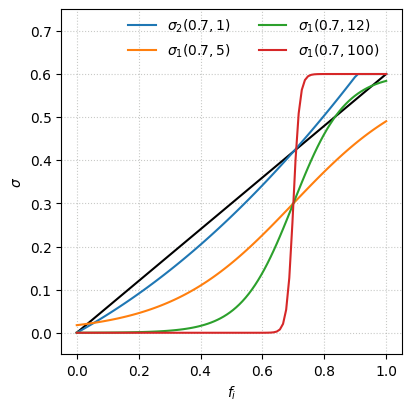

In [98]:
### plot the cross-inhibition used in the last experiment:
fig, ax = plt.subplots(1,1, constrained_layout=True, figsize=(4,4))
ax.grid(color='xkcd:gray', ls=':', alpha=0.5)

xs = np.linspace(0.0,1.0,100)
l = 0.6

# LINEAR FUNCTION:
ax.plot(xs, l*xs, color='xkcd:black')

# SIGMOID FUNCTION:
for ci_kwargs in ci_kwargs_list[1:]:
    if ci_kwargs[0] == 1:
        x0, a = ci_kwargs[1:]
        civals = l*np.array([1/(1+np.exp(-a*(x-x0))) for x in xs])
    elif ci_kwargs[0] == 2:
        x0, a = ci_kwargs[1:]
        civals = l*np.array([min(2*x/(1+np.exp(-a*(x-x0))),1) for x in xs])
    ax.plot(xs, civals, label=fr"$\sigma_{ci_kwargs[0]} ({ci_kwargs[1]}, {ci_kwargs[2]})$")

ax.set(ylim=(-0.05, l+0.15), xlabel=r'$f_i$', ylabel=r'$\sigma$')
ax.legend(ncol=2, frameon=False, loc=(0.18, 0.84))

if ci_kwargs_list[1][1] == ci_kwargs_list[2][1]: # x0 is constant, a is changed
    fig.savefig(f'sim_dif_cimode_sigmoid{ci_kwargs_list[1][0]}_cha_fi_win_perc_pi1_{pis[0]}_pi2_{pis[1]}_q1_{qs[0]}_q2_{qs[1]}_l_{l}_lci_{lci}_ic_{ic}_CIFUNC.png')
else: # x0 is changed, a is constant
    fig.savefig(f'sim_dif_cimode_sigmoid{ci_kwargs_list[1][0]}_chx0_fi_win_perc_pi1_{pis[0]}_pi2_{pis[1]}_q1_{qs[0]}_q2_{qs[1]}_l_{l}_lci_{lci}_ic_{ic}_CIFUNC.png')